In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
sns.set_style('whitegrid')

In [2]:
# LORENZ.DAT
data = pd.read_table('data/LORENZ.DAT', header=None)

# scaling
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = np.array(data).flatten()

In [3]:
# create d-dimensional data
t, d = 16, 3
lagged = []

for i in range(0, d+1):
    lagged.append(np.roll(data, -t*i)[:-t*d])
    
lagged = np.array(lagged).T
lagged.shape
#unlagged = data[:-t]
#lagged = np.roll(data, -t)[:-t]

(16336, 4)

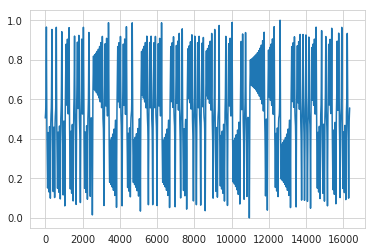

In [4]:
plt.plot(lagged[:, 0])

In [5]:
df = pd.DataFrame(lagged)
df.head()

,0,1,2,3
0,0.505204,0.529104,0.582915,0.804967
1,0.507508,0.530725,0.589690,0.827545
2,0.509557,0.532470,0.597134,0.850338
3,0.511395,0.534358,0.605311,0.872868
4,0.513057,0.536407,0.614286,0.894545


In [6]:
x = df[df.columns[0:-1]]
y = df[df.columns[-1]]

x = np.array(x)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.6,
                                                    random_state=None, shuffle=False)

In [7]:
from sklearn.neural_network import MLPRegressor

In [8]:
clf = MLPRegressor(hidden_layer_sizes=(20), activation='relu',
                   batch_size=200, shuffle=False, solver='adam', random_state=42, verbose=True)
clf.fit(X_train, y_train)

Iteration 1, loss = 0.41596801
Iteration 2, loss = 0.22918683
Iteration 3, loss = 0.10232793
Iteration 4, loss = 0.03815816
Iteration 5, loss = 0.02541954
Iteration 6, loss = 0.02402320
Iteration 7, loss = 0.02298874
Iteration 8, loss = 0.02199958
Iteration 9, loss = 0.02104595
Iteration 10, loss = 0.02015177
Iteration 11, loss = 0.01929136
Iteration 12, loss = 0.01849031
Iteration 13, loss = 0.01773066
Iteration 14, loss = 0.01701451
Iteration 15, loss = 0.01634018
Iteration 16, loss = 0.01570572
Iteration 17, loss = 0.01511269
Iteration 18, loss = 0.01456756
Iteration 19, loss = 0.01406582
Iteration 20, loss = 0.01361365
Iteration 21, loss = 0.01320219
Iteration 22, loss = 0.01283578
Iteration 23, loss = 0.01249711
Iteration 24, loss = 0.01219873
Iteration 25, loss = 0.01193694
Iteration 26, loss = 0.01170173
Iteration 27, loss = 0.01149874
Iteration 28, loss = 0.01131661
Iteration 29, loss = 0.01114616
Iteration 30, loss = 0.01098350
Iteration 31, loss = 0.01083659
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=20, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=False, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [9]:
pred = clf.predict(X_test)
print('R^2 method: ', clf.score(X_train, y_train))
print('R^2 method: ', clf.score(X_test, y_test))
print('R^2 import: ', r2_score(y_test, pred))
print('MSE: ', mean_squared_error(y_test, pred))

R^2 method:  0.6003472495479686
R^2 method:  0.5945055106679509
R^2 import:  0.5945055106679509
MSE:  0.01858851058176273


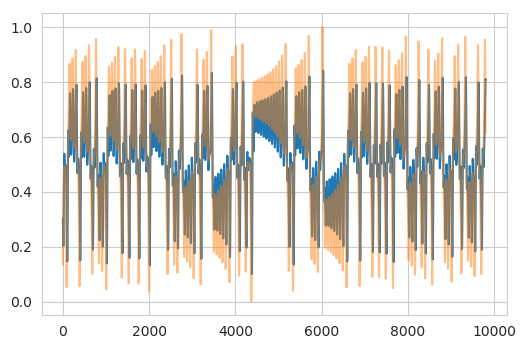

In [10]:
plt.figure(dpi=100)
plt.plot(pred)
plt.plot(y_test, alpha=0.5)

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [12]:
print(keras.wrappers.scikit_learn.__file__)

/home/yura/anaconda3/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py


In [13]:
def build_model():
    model = Sequential()
    model.add(Dense(3, input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(0.0001), kernel_initializer='normal'))
    model.add(Activation('relu'))
    model.add(Dense(20, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer='normal'))
    model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    adam = Adam(epsilon=1e-08)
    model.compile(loss='mse', optimizer=adam)
    #model.summary()
    
    return model

In [14]:
es_cb = EarlyStopping(monitor='binary_crossentropy', verbose=1, mode='auto')

estimator = KerasRegressor(build_fn=build_model, epochs=50, batch_size=200, verbose=1)
estimator.fit(X_train, y_train, shuffle=False) #, callbacks=[es_cb]

Epoch 1/50
6534/6534 [==============================] - 1s 188us/step - loss: 0.2795
Epoch 2/50
6534/6534 [==============================] - 0s 36us/step - loss: 0.2198
Epoch 3/50
6534/6534 [==============================] - 0s 35us/step - loss: 0.1329
Epoch 4/50
6534/6534 [==============================] - 0s 32us/step - loss: 0.0581
Epoch 5/50
6534/6534 [==============================] - 0s 37us/step - loss: 0.0389
Epoch 6/50
6534/6534 [==============================] - 0s 33us/step - loss: 0.0386
Epoch 7/50
6534/6534 [==============================] - 0s 25us/step - loss: 0.0383
Epoch 8/50
6534/6534 [==============================] - 0s 24us/step - loss: 0.0380
Epoch 9/50
6534/6534 [==============================] - 0s 22us/step - loss: 0.0377
Epoch 10/50
6534/6534 [==============================] - 0s 38us/step - loss: 0.0373
Epoch 11/50
6534/6534 [==============================] - 0s 29us/step - loss: 0.0370
Epoch 12/50
6534/6534 [==============================] - 0s 24us/step - l

In [15]:
pred1 = estimator.predict(X_test)
print('R^2 method', estimator.score(X_train, y_train))
print('R^2 method', estimator.score(X_test, y_test))
print('R^2 import', r2_score(y_test, pred1))
print('MSE: ', mean_squared_error(y_test, pred1))

6534/6534 [==============================] - 0s 29us/step
R^2 method -0.02501177655736496
9802/9802 [==============================] - 0s 14us/step
R^2 method -0.024803532799031268
R^2 import 0.4628616278378259
MSE:  0.024623274982736552


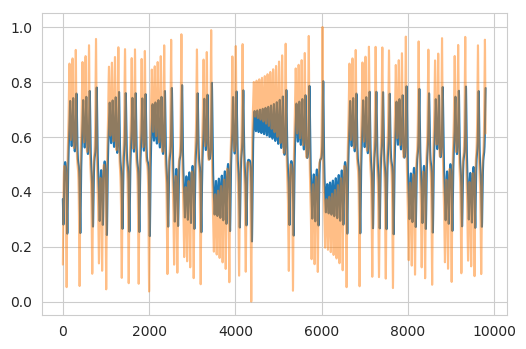

In [16]:
plt.figure(dpi=100)
plt.plot(pred1)
plt.plot(y_test, alpha=0.5)